# HPDM097: Foundations of combinatorial optimisation for routing and scheduling problems in health
# OPTIONAL TOPIC: Patient transport

Many healthcare systems manage assets or workforces that they need to deploy geographically. For example, patient transport services where a fleet of non-emergency ambulances pick up patients from their own home and transport them to outpatient appointments in a clinical setting. These problems can be classified as (Rich) Vehicle Routing Problems. 

To see a real world application of this approach please see [Allen et al. (2020). A simulation modelling toolkit to support dialysis services during the COVID-19 pandemic](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0237628)

---

**In this notebook** you will learn how to 

* Represent a patient transport problem as the capacitated vehicle routing problem (CVRP)
* Gain experience of applying **Iterated Local Search** to model and solve the CRVP.
* Understand the limitations of the CVRP formulation of the problem.

> Vehicle routing problems are inherently intractable: the length of time it takes to solve them grows exponentially with the size of the problem. For sufficiently large problems, it could take routing software years to find the optimal solution.  As in the case of the Travelling Salesman Problem we need to apply algorithms that provide good or near optimal solutions to the problem.

# Imports

In [1]:
import numpy as np
import pandas as pd
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from metapy.tsp.euclidean import gen_matrix, euclidean_distance

from metapy.local_search.hill_climbing import (HillClimber,
                                               TweakTwoOpt)

from metapy.local_search.ils import (IteratedLocalSearch,
                                     HigherQualityHomeBase,
                                     RandomHomeBase,
                                     EpsilonGreedyHomeBase,
                                     AnnealingEpsilonGreedyHomeBase,
                                     TempFastCoolingSchedule,
                                     DoubleBridgePertubation,
                                     TabuDoubleBridgeTweak)

#objective for unit demand (individual patients) CVRP
from metapy.tsp.objective import CVRPUnitDemandObjective

from joblib import Parallel, delayed

## Helper functions

The notebook includes a number of utility functions to facilitate your exploration of the CVRP.  Feel free to explore and ask questions about them.  They provide the ability to run the ILS algorithm multiple times in parallel (using `joblib`), generate a random CVRP problem and plot the result.

In [2]:
def multiple_runs(n_patients, random_states, ils_iter, instance_seed=101, 
                  n_jobs=-1):
    '''
    Perform multiple parallel runs of ILS    
    '''
    x_coords, y_coords = generate_instance(n_patients, 
                                           random_state=instance_seed)
    
    coords = [[x, y] for x, y in zip(x_coords, y_coords)]
    matrix = gen_matrix(np.array(coords))
    
    
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(n_patients, matrix, rs, 
                   ils_iter) for rs in random_states)
    
    return res

def single_run(n_patients, distance_matrix, random_state, ils_iter=20):
    '''
    Perform a single run of ILS
    '''
    init_solution = np.arange(n_patients+1)
    ils_solver = create_solver(distance_matrix, 
                               4, 
                               init_solution, 
                               random_state=random_state)
    ils_solver.run(n=ils_iter)
    return ils_solver.get_best_solutions()[0]

In [3]:
def plot_solution(routes, x_coords, y_coords, figsize=(9,6)):
    '''
    Plot a solution to the CVRP
    '''
    xc = x_coords
    yc = y_coords
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    for route in routes:
        
        for k in range(len(route)-1):
            i, j = route[k], route[k+1]
            ax.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
            
        ax.plot([xc[route[-1]], xc[0]], [yc[route[-1]], yc[0]], c='green')
        ax.plot([xc[route[0]], xc[0]], [yc[route[0]], yc[0]], c='green')
    
    ax.plot(xc[0], yc[0], c='r', marker='^')
    ax.scatter(xc[1:], yc[1:], c='b')
    
    i = 1
    for x, y in zip(x_coords[1:], y_coords[1:]):
        #plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
        i += 1
    
    return fig, ax

In [4]:
def generate_instance(n_patients, random_state=None):
    '''
    Generate a random instance of the CVRP
    
    Params:
    ------
    n_patients: int
        Number of patients to include in the instance
        
    random_state: int
        seed for random numbers
        
    Returns:
        np.ndarray, np.ndarray
        x coordinations, y coordinates
    '''

    #random number generator for synthetic data.
    rand_gen = RandomState(seed=random_state)

    #n_patients = 1 so we include the depot
    x_coords = rand_gen.random(size=n_patients+1) * 200
    y_coords = rand_gen.random(size=n_patients+1) * 100

    return x_coords, y_coords

In [5]:
def plot_patient_coordinates(x_coords, y_coords, figsize=(12,6)):
    '''
    Plot a simple scatter of coordinates. 
    Depot is red, customers are blue
    
    Params:
    --------
    x_coords: array-like
        x coordinates for each patient. element 0 = depot.
        
    y_coords: array-like
        y coordinates for each patient. element 0 = depot
    '''
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(x_coords[0], y_coords[0], c='r', marker='^', ms=10)
    
    for i in range(1, len(x_coords[1:])):
        x = x_coords[i]
        y = y_coords[i]
        ax.plot(x, y, 'b*')
        ax.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
    
    plt.xlim((0, 220))
    plt.ylim((0, 120))
    return fig, ax

In [6]:
def convert_tour_to_routes(tour, capacity):
    '''
    Easy as demand comes in single units and
    capacity is an integer
    '''
    n_cities = len(tour)
    capacity = int(capacity)
    splits = [i for i in range(capacity, n_cities, capacity)]
    routes = np.split(tour, splits)
    return routes

In [7]:
def create_solver(matrix, capacity, init_solution, random_state=None):
    '''
    create an instance of a ILS solver
    '''
    
    # CVRP objective'
    cvrp_obj = CVRPUnitDemandObjective(matrix, 0, capacity)
    
    #Hill climber
    local_search = HillClimber(objective=cvrp_obj,
                               init_solution=init_solution,
                               tweaker=TweakTwoOpt(), 
                               maximisation=False)
    
    #iterated local search
    ils = IteratedLocalSearch(local_search, 
                              accept=EpsilonGreedyHomeBase())
    return ils

## Generating a test problem instance.

To create an synthetic instance of the CVRP you can use the `generate_instance` function.  The `random_state` parameter allows you to recreate problems.  The code below is set up to produce a 30 patient problem.

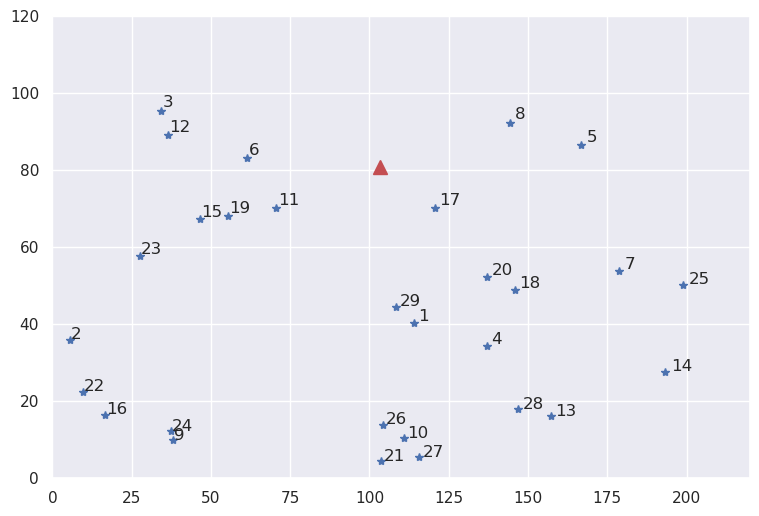

In [8]:
N_PATIENTS = 30
SEED = 101

#visualise
x_coords, y_coords = generate_instance(N_PATIENTS, random_state=SEED)
fig, ax = plot_patient_coordinates(x_coords, y_coords, figsize=(9,6))
fig.savefig('vrp.png', bbox_inches='tight', dpi=150)

# Representing the routes

In [9]:
N_PATIENTS = 20

#solution is represented as vector as in TSP
init_solution = np.arange(N_PATIENTS)

#we can see the subtours by simply splitting by capacity
#note there are other methods to do this.
convert_tour_to_routes(init_solution, capacity=4)

[array([0, 1, 2, 3]),
 array([4, 5, 6, 7]),
 array([ 8,  9, 10, 11]),
 array([12, 13, 14, 15]),
 array([16, 17, 18, 19])]

# Solution using Iterated Local Search

* ILS is part of a family of methods called meta-heuristics.  
* These allow you to get a 'good' solution quickly, but it may not be optimal.

In [10]:
%%time 
N_PATIENTS = 30
INSTANCE_SEED = 101
ILS_ITERS = 100 

#create patient data, distance between patients and initial solution.
x_coords, y_coords = generate_instance(N_PATIENTS, random_state=INSTANCE_SEED)
coords = [[x, y] for x, y in zip(x_coords, y_coords)]
init_solution = np.arange(N_PATIENTS+1)
distance_matrix = gen_matrix(np.array(coords))

#use ILS to generate a 'good' solution.
ils_solver = create_solver(distance_matrix, 4, init_solution, random_state=28)
ils_solver.run(n=ILS_ITERS)

print(f'ILS solution: {ils_solver.get_best_solutions()[0]:.2f}')

ILS solution: -1456.64
CPU times: user 9.27 s, sys: 7.79 ms, total: 9.28 s
Wall time: 9.29 s


# Visuliase routes as a plot

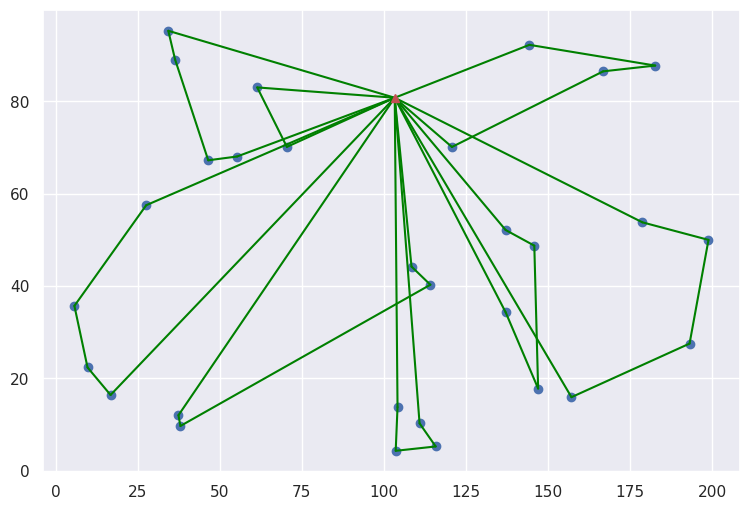

In [11]:
solution = ils_solver.get_best_solutions()[1][0]
routes = convert_tour_to_routes(solution[1:], 4)
fig, ax = plot_solution(routes, x_coords, y_coords)
fig.savefig('vrp_solution.png', bbox_inches='tight', dpi=150)

# Multiple runs of the algorithm

As ILS is a stochastic algorithm, it is instructive to run it multiple times to quantify its performance on average (and best and worst cases).  The code listing below performs multiple runs for you.  Note that when `n_jobs=-1` the function performs the runs in parallel.  This means that you can take advantage of the virtual cores on your machine and get results in less time. 

In [12]:
import time

start = time.time()

#use a reasonably big problem sized 60 - 100 is challenging and may take 30s.
N_PATIENTS = 60

#three runs of ILS to examine avg performance...
results = multiple_runs(N_PATIENTS, [19, 41, 28], ils_iter=20, n_jobs=-1)
print(results, end='=> ')
print(f'mean: {np.mean(results):.2f}')
print(f'time taken: {time.time() - start:.2f}s')

[np.float64(-2548.835288362566), np.float64(-2529.0736300727212), np.float64(-2553.1200866396566)]=> mean: -2543.68
time taken: 23.56s
